In [1]:
import cv2
import os
import glob
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Define and instantiate line objects

In [2]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None


# Lane Detector Class

In [16]:
class Finder(object):
    def __init__(self, camera_calfile='camera_cal.p'):
        self.left_line=Line()
        self.right_line=Line()
        # load calibration file 
        with open(camera_calfile, mode='rb') as f:
            camera_cal=pickle.load(f)
        self.mtx=camera_cal['mtx']
        self.dist=camera_cal['dist']        
        
    # Use color transforms, gradients, etc., to create a thresholded binary image.
    # Colour transform
    def color_thresh(self, img, thresh=(0,255), hue_thresh=(0,30)):
        hls=cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h=hls[:,:,0]
        s=hls[:,:,2]

        # Color threshold to isolate yellow and white 
        s_binary=np.zeros_like(s)
        s_binary[[((s>=thresh[0]) & (s<=thresh[1]))]]=1

        h_binary=np.zeros_like(s)
        h_binary[[((h>=hue_thresh[0]) & (h<=hue_thresh[1]))]]=1    

        color_binary=np.zeros_like(s)
        color_binary= s_binary & h_binary
        #plt.imshow(np.dstack((255*s_binary,np.zeros_like(s), s)))
        #plt.show()
        return (color_binary)
    
    def abs_sobel_thresh(self, gray, orient='x', sobel_kernel=3, thresh=(0,255)):

        # Apply the following steps to img
        # 2) Take the derivative in x or y given orient = 'x' or 'y'
        #default is to use sobel x
        if orient=='x':
            gradient=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
        if orient=='y':
            gradient=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)        

        # 3) Take the absolute value of the derivative or gradient
        abs_grad=np.absolute(gradient)

        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scale_factor=np.max(abs_grad)/255.0
        abs_grad=(abs_grad/scale_factor).astype(np.uint8)

        # 5) Create a mask of 1's where the scaled gradient magnitude 
                # is > thresh_min and < thresh_max
        mask=[(abs_grad>thresh[0]) & (abs_grad<thresh[1])]

        # 6) Return this mask as your binary_output image
        binary_output=np.zeros_like(abs_grad).astype(np.uint8)
        binary_output[mask]=1    
        return binary_output

    def mag_thresh(self, gray, sobel_kernel=3, mag_thresh=(0, 255)):

        # Apply the following steps to img
        # 2) Take the gradient in x and y separately
        sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Calculate the magnitude
        sobel_mag=np.sqrt(sobelx**2+sobely**2)
        # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        with np.errstate(divide='ignore', invalid='ignore'):
            sobel_mag=np.uint8(255*sobel_mag/np.max(sobel_mag))
        # 6) Create a binary mask where mag thresholds are met
        mask =[(sobel_mag > mag_thresh[0]) & (sobel_mag < mag_thresh[1])]
        # 7) Return this mask as your binary_output image
        binary_output=np.zeros_like(sobel_mag).astype(np.uint8)
        binary_output[mask] = 1
        return binary_output

    def dir_threshold(self, gray, sobel_kernel=3, thresh=(0, np.pi/2)):    
        # 2) Take the gradient in x and y separately
        sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Calculate the direction of the gradient 
        with np.errstate(divide='ignore', invalid='ignore'):
            sobel_phase=np.arctan(sobely/(sobelx))
            # 4) Take the absolute value
            sobel_abs_phase=np.absolute(sobel_phase)
            # 5) Create a binary mask where direction thresholds are met
            mask =[(sobel_abs_phase > thresh[0]) & (sobel_abs_phase < thresh[1])]
            # 6) Return this mask as your binary_output image
            dir_binary=np.zeros_like(sobel_abs_phase).astype(np.uint8)
            dir_binary[mask] = 1
        return dir_binary

    def detect_sobel_edges(self, gray):
        ksize=13
        gradx = self.abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
        grady = self.abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(10, 255))
        mag_binary = self.mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(50, 255))
        dir_binary = self.dir_threshold(gray, sobel_kernel=ksize, thresh=(0.15*np.pi/2, 0.85*np.pi/2))

        edges = np.zeros_like(dir_binary)
        #edges[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
        edges[((gradx == 1) & (dir_binary == 1) & (mag_binary == 1))] = 1
        #edges[((gradx == 1) )] = 1

        return edges

    # Region masking
    def region_masking(self, img):
        ysize = img.shape[0]
        xsize = img.shape[1]

        left_bottom = [0.0*xsize, ysize-1]
        left_top = [0.45*xsize, 0.6*ysize]
        right_top = [0.55*xsize, 0.6*ysize]
        right_bottom = [1*xsize, ysize-1]

        # Fit lines (y=Ax+B) to identify the  3 sided region of interest
        # np.polyfit() returns the coefficients [A, B] of the fit
        fit_left = np.polyfit((left_bottom[0], left_top[0]), (left_bottom[1], left_top[1]), 1)
        fit_top = np.polyfit((left_top[0], right_top[0]), (left_top[1], right_top[1]), 1)
        fit_right = np.polyfit((right_top[0], right_bottom[0]), (right_top[1], right_bottom[1]), 1)
        fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

        # Find the region inside the lines
        XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
        region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                            (YY > (XX*fit_top[0] + fit_top[1])) & \
                            (YY > (XX*fit_right[0] + fit_right[1])) & \
                            (YY < (XX*fit_bottom[0] + fit_bottom[1]))

        binary_lane=np.zeros_like(img)
        binary_lane[region_thresholds & (img==1)]=1

        return binary_lane    
    
    def bird_eye(self, img, src_pts, dst_pts):

        M = cv2.getPerspectiveTransform(src_pts,dst_pts)

        warped=cv2.warpPerspective(img,M,img.shape[::-1],flags=cv2.INTER_LINEAR)
        return warped, M

    # Find lane boundary
    # Function to find lane boundary and return an binary image
    def find_lane(self, img, x_init_pos, wdw_dx=100, wdw_dy=4*36):
        shape_ymax, shape_xmax=img.shape
        windowed=np.zeros_like(img)
        # start the search from peak
        x_mean=x_init_pos
        for y in range(shape_ymax, 0, -wdw_dy):
            wdw=img[y-wdw_dy:y,x_mean-wdw_dx:x_mean+wdw_dx].copy()
            windowed[y-wdw_dy:y,x_mean-wdw_dx:x_mean+wdw_dx]=wdw.copy()
            # Calculate new mean of x
            histogram = np.sum(wdw, axis=0)
            if (np.sum(histogram)!=0): # found pixels, update the mean location        
                x_mean=x_mean-wdw_dx+np.argmax(histogram)

            #print(histogram)
            #print(x_init_pos, np.argmax(histogram), x_mean)
        return windowed

    # Detect lane pixels and fit to find lane boundary
    def find_lane_boundary(self, img, left_start, right_start, dbg=False):
        # mask the bottom centre area
        shape_ymax, shape_xmax=img.shape    
        x_center=int(shape_xmax/2)
        img[shape_ymax-100:shape_ymax,x_center-150:x_center+150]=0        

        left_lane=self.find_lane(img, left_start)
        right_lane=self.find_lane(img, right_start)

        return left_lane, right_lane 

    # Determine curvature of the lane and vehicle position with respect to center
    def fit_polynomial(self, lane_img, line, dbg=False):

        shape_ymax, shape_xmax = lane_img.shape
        y = np.linspace(0, shape_ymax, num=shape_ymax)

        # Get the x,y indexes with non-zero elements i.e. white lines
        line.ally,line.allx=np.nonzero(lane_img)

        # Polynomial fitting
        line.fit=np.polyfit(line.ally,line.allx,2)
        line.recent_xfitted = line.fit[0]*y**2 + line.fit[1]*y + line.fit[2]

        y_bottom=shape_ymax-1
        line.line_base_pos = line.fit[0]*y_bottom**2 + line.fit[1]*y_bottom + line.fit[2]
        if dbg==True:
            print("polynomial", line.fit)
            print("base pos ", line.line_base_pos)
            # Plt on graph
            plt.plot(line.allx, line.ally, '.', color='white')
            plt.plot(line.recent_xfitted, y, color='red', linewidth=3)

            plt.xlim(0, 1280)
            plt.ylim(0, 720)
            ax = plt.gca()
            ax.set_axis_bgcolor('black')
            plt.gca().invert_yaxis()
            plt.show()

    def calc_curvature(self, lane_img, line, xm_per_pix, ym_per_pix):
        # Curvature
        y_eval=lane_img.shape[0]
        fit_cr=np.polyfit(line.ally*ym_per_pix,line.allx*xm_per_pix,2)

        line.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])


    def fill_poly_unwarp(self, img, warped, warp_matrix, left_fit, right_fit):
        # Warp the detected lane boundaries back onto the original image
        shape_ymax, shape_xmax, _ =img.shape
        y = np.linspace(0, shape_ymax, num=shape_ymax)
        left_fitted_curve = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
        right_fitted_curve = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]    
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        pts_left = np.array([np.transpose(np.vstack([left_fitted_curve, y]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitted_curve, y])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        Minv=np.linalg.inv(warp_matrix)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        return result

    def process_image(self, img, dbg=False):
        shape_ymax, shape_xmax, _ = img.shape
        #Apply distortion correction to the raw image
        undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        if dbg==True:
            plt.imshow(undist)
            plt.show()

        # Threshold color
        color_binary=self.color_thresh(undist, (100,255))

        if dbg==True:
            plt.imshow(color_binary, cmap='gray')
            plt.show()
            print('Color Masking')

        # Threshold gradient
        gray=cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
        edges=self.detect_sobel_edges(gray)
        if dbg==True:
            plt.imshow(edges, cmap='gray')
            plt.show()
            print('Edge detection')

            plt.imshow(255*np.dstack((color_binary,np.zeros_like(edges),edges)))
            plt.show()
            print('Color Masking stack with Edge detection')


        # Combine gradient and color thresholds
        grad_color_masked=np.zeros_like(color_binary)
        grad_color_masked[(edges==1) | (color_binary==1)]=1        

        if dbg==True:
            plt.imshow(grad_color_masked, cmap='gray')
            plt.show()
            print('Color Masking OR Edge detection')

        binary_lane=self.region_masking(grad_color_masked)
        if dbg==True:
            plt.imshow(binary_lane, cmap='gray')
            plt.show()
            print('After region masking')

        # Warp
        """
        src_pts=find_trapezoid_corners(binary_lane)
        temp_img=img.copy()
        color=[255,0,0]
        thickness=5
        cv2.line(temp_img, (src_pts[0][0], src_pts[0][1]), (src_pts[1][0], src_pts[1][1]), color, thickness)    
        cv2.line(temp_img, (src_pts[1][0], src_pts[1][1]), (src_pts[2][0], src_pts[2][1]), color, thickness)    
        cv2.line(temp_img, (src_pts[2][0], src_pts[2][1]), (src_pts[3][0], src_pts[3][1]), color, thickness)        
        plt.imshow(temp_img)
        plt.show()
        print(src_pts)
        """
        src_pts=np.array([[271, shape_ymax], [453, 576], [925, 576], [1178, shape_ymax]],np.int)
        dst_pts=np.array([[290, shape_ymax],[290, 0.85*shape_ymax],
                      [990,0.85*shape_ymax],[990,shape_ymax]],np.int)

        warped, warp_matrix=self.bird_eye(binary_lane, np.float32(src_pts), np.float32(dst_pts))
        if dbg==True:
            plt.imshow(warped,cmap='gray')
            plt.show()
            print('warped')

        # Plot the trapezoid
        """
        if dbg==True:    
            line_pic = undist.copy()
            color=[255,0,0]
            thickness=10
            cv2.line(line_pic, (src_pts[0][0], src_pts[0][1]), (src_pts[1][0], src_pts[1][1]),color, thickness)
            cv2.line(line_pic, (src_pts[1][0], src_pts[1][1]), (src_pts[2][0], src_pts[2][1]),color, thickness)
            cv2.line(line_pic, (src_pts[2][0], src_pts[2][1]), (src_pts[3][0], src_pts[3][1]),color, thickness)
            cv2.line(line_pic, (src_pts[3][0], src_pts[3][1]), (src_pts[0][0], src_pts[0][1]),color, thickness)
            plt.imshow(line_pic)
            plt.show()
        """


        # Find lanes
        left_lane,right_lane=self.find_lane_boundary(warped, dst_pts[0][0],dst_pts[3][0],dbg)
        #if dbg==True:    
        #    plt.imshow(left_lane,cmap='gray')
        #    plt.show()
        #    plt.imshow(right_lane,cmap='gray')
        #    plt.show()

        combine_lanes=cv2.addWeighted(left_lane,1,right_lane,1,0)
        if dbg==True:
            plt.imshow(combine_lanes,cmap='gray')
            plt.show()
            print('Found lanes')


        # Find curvature 
        self.fit_polynomial(left_lane, self.left_line, dbg=dbg)
        self.fit_polynomial(right_lane, self.right_line, dbg=dbg)

        # Calculate the position of car relative to lane center
        # Define conversions in from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension

        lane_width_m = 3.7
        xm_per_pix = lane_width_m/(self.right_line.line_base_pos-self.left_line.line_base_pos)
        car_center=img.shape[1]/2
        lane_center=(self.left_line.line_base_pos+self.right_line.line_base_pos)/2    
        lane_offset=xm_per_pix*(car_center-lane_center)

        # calculate correlation coefficient
        corr_coef=np.correlate(self.left_line.fit[0:2], self.right_line.fit[0:2])
        self.calc_curvature(left_lane, self.left_line, xm_per_pix, ym_per_pix)
        self.calc_curvature(right_lane, self.right_line, xm_per_pix, ym_per_pix)

        if dbg==True:
            print('correlation coefficient', corr_coef)
            print('lane_offset',lane_offset,'m')

        if corr_coef>0:
            self.left_line.best_fit=self.left_line.fit
            self.right_line.best_fit=self.right_line.fit

        curverad=np.minimum(self.left_line.radius_of_curvature, self.right_line.radius_of_curvature)

        # fill polygon and unwarp into original image
        result=self.fill_poly_unwarp(undist, warped, warp_matrix, self.left_line.best_fit, self.right_line.best_fit)


        # add texts
        cv2.putText(result, "Radius of Curvature ="+str(int(curverad))+"(m)", (20, 50),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2)
        if lane_offset>0:
            side="right"
        else:
            side="left"

        cv2.putText(result, "Vehicle is"+" %0.2fm "%(np.abs(lane_offset))+side+" of center", (20, 100),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2)

        #cv2.putText(result, "Correlation is"+" %0.4f "%(corr_coef), (300, 450),
        #           cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2)

        if dbg==True:    
            plt.imshow(result)
            plt.show()
        return result

# Pipeline for Lane Detection

In [17]:
lane_detector=Finder('camera_cal.p')

# Test Images

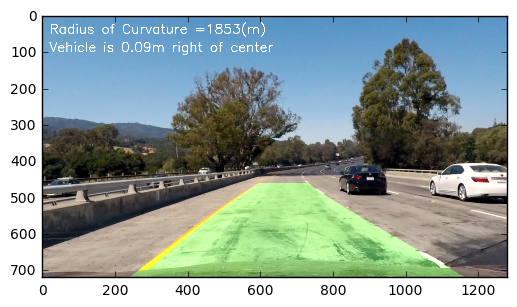

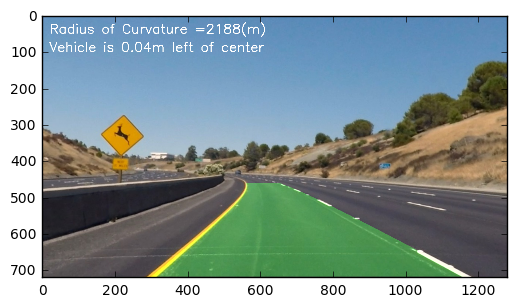

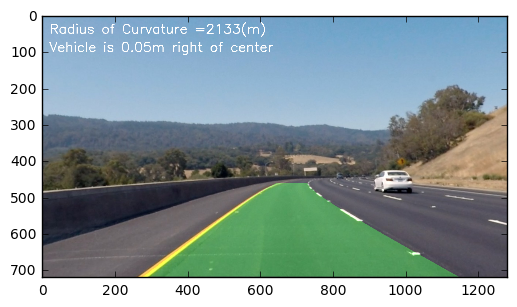

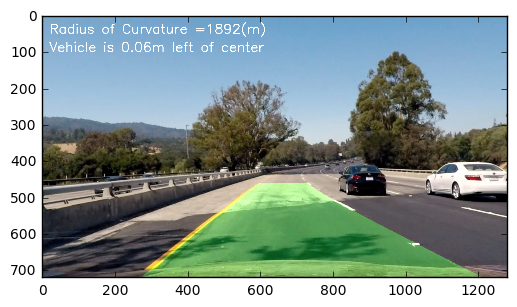

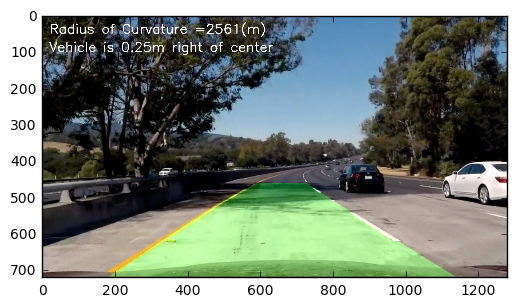

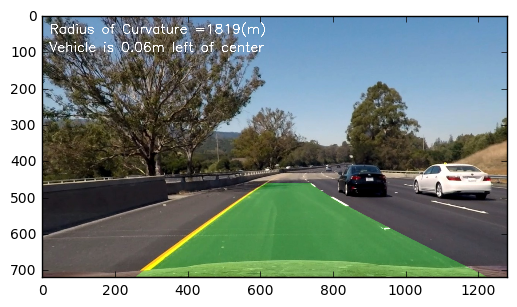

In [18]:
img_path=os.getcwd()+'/test_images/'
for filename in glob.iglob(img_path+'test*.jpg'):    
    #img=mpimg.imread(img_path+'test4.jpg')
    img=mpimg.imread(filename)
    ret=lane_detector.process_image(img, dbg=False)
    plt.imshow(ret)
    plt.show()

# Run in on Video

In [12]:
def image_pipeline(img):
    global left_line, right_line
    return process_image(img, left_line, right_line)
                  
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip_output = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time clip_output.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [10:12<00:00,  1.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 

Wall time: 10min 15s


# For Debugging

In [20]:
cap = cv2.VideoCapture("project_video.mp4") #video_name is the video being called
for fn in range(1060,1061): # enter the range of frames to view
    cap.set(1,fn); # Where frame_no is the frame you want
    ret, frame = cap.read() # Read the frame
    cv2.imwrite('test1060.jpg',frame)
    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    aug_frame=process_image(frame, left_line, right_line,dbg=False)
    
    aug_frame=cv2.cvtColor(aug_frame,cv2.COLOR_RGB2BGR)
    cv2.putText(aug_frame, "Frame "+str(fn), (400, 450),
           cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)    
    
    cv2.imshow('window_name', aug_frame) # show frame on window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cv2.destroyAllWindows()    